In [32]:
# Disable warnings for cleaner output (no more deprecation warnings from packages used within packages).
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
df = pd.read_csv("data/ExtractedTweets.csv")

# Adjustable sample size and ensure even distribution between Parties.
democrat = df.query("Party == 'Democrat'").sample(20000)
republican = df.query("Party == 'Republican'").sample(20000)

df_slim = democrat.append(republican)
df_slim.head()
df = df_slim

### Clean metioned, retweets and hashtags from tweet

In [3]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\-.,;:!/?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df['TweetCleaned'] = df['Tweet'].apply(clean)

print("Cleaned tweets")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dslh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned tweets


### Lemmatize the text

In [4]:
import spacy
# python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df['TweetCleaned'] = df['TweetCleaned'].apply(lemmatization)
print("Lemmatized tweets")

Lemmatized tweets


In [5]:
import gensim
# Use gensims simple_preprocess to remove accents, lowercase and tokenize.
def gen_words(tweet):
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df['TweetWords'] = df['TweetCleaned'].apply(gen_words)
print("Generated tokens")

Generated tokens


In [6]:
# Create bigrams and trigrams.
bigram_phrases = gensim.models.Phrases(df['TweetWords'], threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['TweetWords']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(tweetWords):
    return bigram[tweetWords]

def make_trigrams(bigrams):
    return trigram[bigram[bigrams]]

df['bigramms'] =  df['TweetWords'].apply(make_bigrams)
df['trigrams'] = df['bigramms'].apply(make_trigrams)
print("Generated trigrams")

Generated trigrams


### TF-IDF REMOVAL

In [7]:
# Remove words using TF-IDF with a lower score than the threshold.
from gensim.models import TfidfModel
import gensim.corpora as corpora

id2word = corpora.Dictionary(df['trigrams'])
corpus = [id2word.doc2bow(text) for text in df['trigrams']]
tfidf = TfidfModel(corpus, id2word=id2word)

threshold = 0.15
words  = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] # reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < threshold]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # words with tf-idf score 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

# Remove empty entries.
corpus = [x for x in corpus if x != []]

print("TF-IDF removal complete")

TF-IDF removal complete


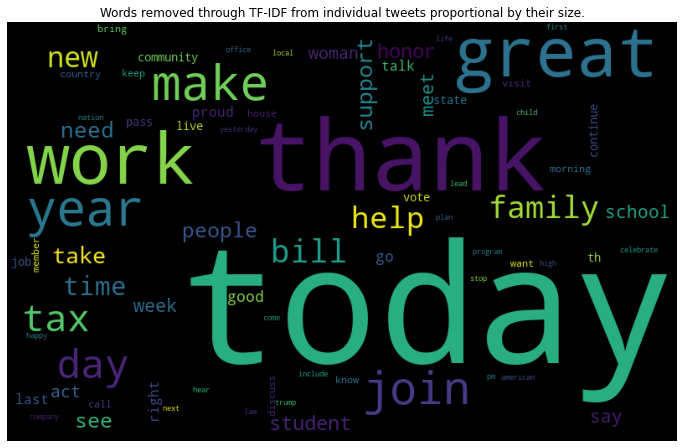

In [33]:
# Visualize removed words in wordcloud.
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(collocations=False, width = 800, height = 500).generate(" ".join(words))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Words removed through TF-IDF from individual tweets proportional by their size.")
plt.savefig("img/diff_wordcloud_tfidf.pdf")

In [9]:
# Save preprocessed data for reuse without rerunning.
import pickle
file = open("data.bin", "wb")
pickle.dump((df, id2word, corpus, tfidf), file)
file.close()

In [10]:
import pickle
(df, id2word, corpus, tfidf) = pickle.load(open("data.bin", "rb"))

In [11]:
# Create topic vector from given model and trigrams.
def get_document_topic(model, tri):
    doc_bow = id2word.doc2bow(tri)
    vec = model.get_document_topics(bow=doc_bow, minimum_probability=0)
    return [v for _, v in vec]

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# Train and predict with multiple classifiers with topic vectors from a given lda model.
def evaluate_model(model):
    result = {}
    df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(model, trigram))
    df['len'] = df['topic_vec'].apply(lambda x: len(x))
    text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=123, test_size=0.30, shuffle=True)

    classifiers = [('MLP', MLPClassifier()), ('G-NB', GaussianNB()), ('L-SVM', LinearSVC())]
    for name, cl in classifiers:
        # Train and predict
        cl.fit(text_train.to_list(), label_train)
        prediction = cl.predict(text_test.to_list())

        # Confusion matrix
        confusion_mtx = confusion_matrix(label_test, prediction)
        accuracy = accuracy_score(label_test, prediction)
        precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')
        result[name] = confusion_mtx, accuracy, precision, recall, fscore
    return result

In [13]:
import gensim
from gensim.models import CoherenceModel

# Create lda models with increasing number of topics and evaluate each model.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    perplexitiy_values = []
    coherence_values = []
    model_list = []
    evaluations = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    random_state=123,
                    per_word_topics=True,
                    # set workers to real CPU cores - 1
                    workers=7
                )
        print("############ Generated model with " + str(num_topics) + " topics ############")
        model_list.append(model)
        # Perplexity
        perplexity = model.log_perplexity(corpus)
        perplexitiy_values.append(perplexity)
        # Coherence
        coherencemodel = CoherenceModel(model=model, corpus=corpus, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        print('Perplexity:', perplexity, ' | ','Coherence:', str(coherencemodel.get_coherence()))
        # Evaluation
        evaluation = evaluate_model(model)
        evaluations.append(evaluation)
        for classifier, eval in evaluation.items():
            confusion_mtx, accuracy, precision, recall, fscore = eval
            print(
            '''{name:5s} | Accuracy: {ac:1.10f}    Precision: {ps:1.10f}    Recall: {rc:1.10f}    F1: {f1:1.10f}'''.format(
                name=classifier,
                #confusion_mtx=confusion_mtx,
                ac=accuracy,
                ps=precision,
                rc=recall,
                f1=fscore
            ))

    return model_list, perplexitiy_values, coherence_values, evaluations

In [14]:
# Evaluate lda models over a given range of topics with classifiers from "evaluate_model".
topic_limit=180
topic_start=5
topic_step=5

model_list, perplexitiy_values, coherence_values, evaluations = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['trigrams'], start=topic_start, limit=topic_limit, step=topic_step)

############ Generated model with 5 topics ############
Perplexity: -8.195112121142387  |  Coherence: -3.8664267704733035
MLP   | Accuracy: 0.5578333333    Precision: 0.5587368663    Recall: 0.5584778688    F1: 0.5575493784
G-NB  | Accuracy: 0.5442500000    Precision: 0.5438371367    Recall: 0.5436527955    F1: 0.5434155634
L-SVM | Accuracy: 0.5297500000    Precision: 0.5314333848    Recall: 0.5309259009    F1: 0.5283188375
############ Generated model with 10 topics ############
Perplexity: -8.441357159614112  |  Coherence: -3.897922169907121
MLP   | Accuracy: 0.5873333333    Precision: 0.5883560442    Recall: 0.5879785215    F1: 0.5870786871
G-NB  | Accuracy: 0.5519166667    Precision: 0.5517426841    Recall: 0.5505375399    F1: 0.5485844645
L-SVM | Accuracy: 0.5224166667    Precision: 0.5243827090    Recall: 0.5238173048    F1: 0.5202252924
############ Generated model with 15 topics ############
Perplexity: -8.615864766048606  |  Coherence: -3.973299298325935
MLP   | Accuracy: 0.59

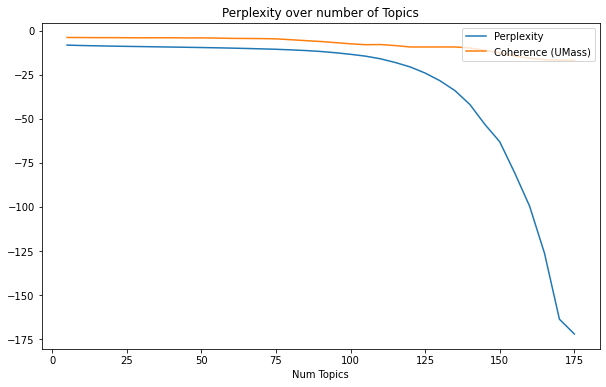

In [15]:
# Plot Perplexity and Coherence (UMass) over number of topics (higher is better).
import matplotlib.pyplot as plt

x = range(topic_start, topic_limit, topic_step)
plt.figure(figsize=(10,6))
plt.title("Perplexity over number of Topics")
plt.plot(x, perplexitiy_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.legend(['Perplexity', 'Coherence (UMass)'], loc="upper right")
plt.savefig("img/perplexity_coherence_over_topics.pdf")
plt.show()

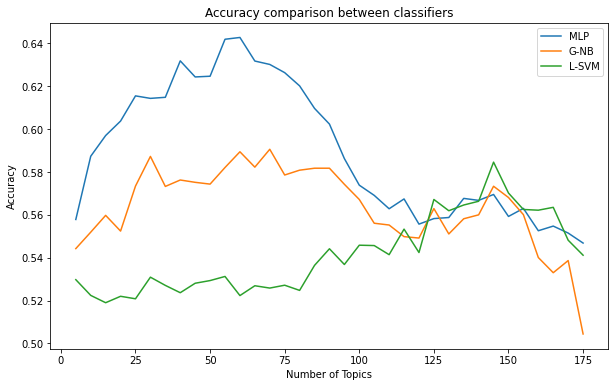

In [16]:
# Create classifier comparison for multiple scores
import matplotlib.pyplot as plt

scores = {name: [] for name in evaluations[0].keys()}
for evaluation in evaluations:
    for name, ev in evaluation.items():
        confusion_mtx, accuracy, precision, recall, fscore = ev
        # Change input in append for different output: accuracy, precision, recall, fscore
        scores[name].append(accuracy)

plt.figure(figsize=(10,6))
plt.title("Accuracy comparison between classifiers")
plt.ylabel("Accuracy")
plt.xlabel("Number of Topics")
for label, score in scores.items():
    plt.plot(x, score, label=label)
plt.legend()
plt.savefig("img/classifier_accuracies_over_topics.pdf")
plt.show()

<Figure size 432x288 with 0 Axes>

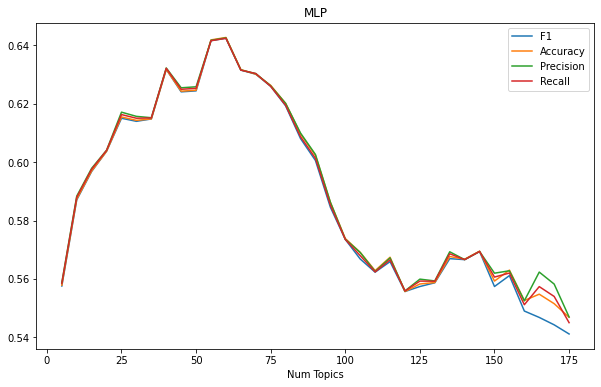

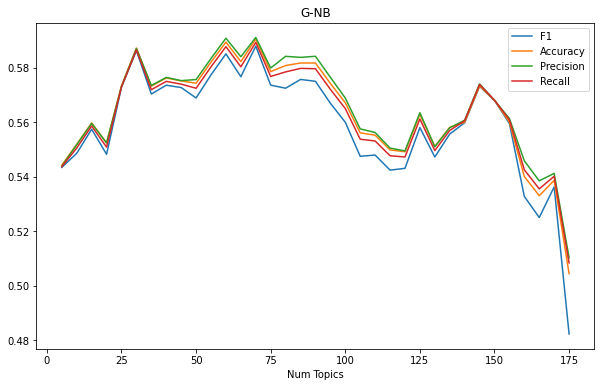

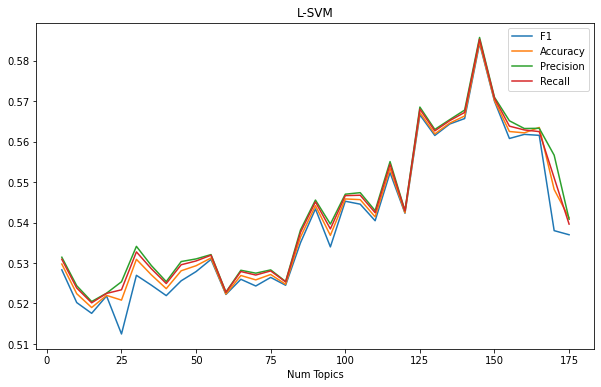

In [17]:
# Plot all evaluation values for each classifier.
import matplotlib.pyplot as plt

names = evaluations[0].keys()
x = range(topic_start, topic_limit, topic_step)
plt.clf()

for name in names:
    f1 = []
    acc = []
    pre = []
    rec = []
    evs = []

    for evaluation in evaluations:
        for inner_name, ev in evaluation.items():
            if inner_name == name:
                evs.append(ev)
    for ev in evs[:40]:
    # evaluation: confusion_mtx, accuracy, precision, recall, fscore
        confusion_mtx, accuracy, precision, recall, fscore = ev

        f1.append(fscore)
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
    plt.figure(figsize=(10,6))
    plt.title(name)
    plt.plot(x, f1, label = 'F1')
    plt.plot(x, acc, label = 'Accuracy')
    plt.plot(x, pre, label = 'Precision')
    plt.plot(x, rec, label = 'Recall')
    plt.xlabel("Num Topics")
    plt.ylabel("")
    plt.legend()
    plt.savefig("img/evaluation_" + name.lower() + ".pdf")

In [24]:
# Create single lda model for manually setting parameters like number of topics.
import gensim

lda_model = gensim.models.LdaMulticore(
                corpus=corpus[:-1],
                id2word=id2word,
                num_topics=60,
                random_state=123,
                per_word_topics=True,
                # set workers to real CPU cores - 1
                workers=7
            )

In [25]:
# After determining MLP as the most promising classifier, hyperparameter optimization with Grid Search was used to decide the best parameter values.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
parameter_space = {
    'hidden_layer_sizes': [(150,), (250,), (350,), (450,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'max_iter': [50, 100, 200]
}

#text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=123, test_size=0.30, shuffle=True)
#cl = MLPClassifier()
#clf = GridSearchCV(cl, parameter_space, n_jobs=-1, cv=5)
#clf.fit(text_train.to_list(), label_train)
#print('Best parameters found:\n', clf.best_params_)

#Best parameters found:
# {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (250,), 'learning_rate': 'invscaling', 'max_iter': 100, 'solver': 'lbfgs'}

Confusion:
 [[3564 2327]
 [1942 4167]]
Accuracy: 0.64425
Precision: 0.6444815471902814
Recall: 0.6435495142160667
F1Score: 0.6433494350327975


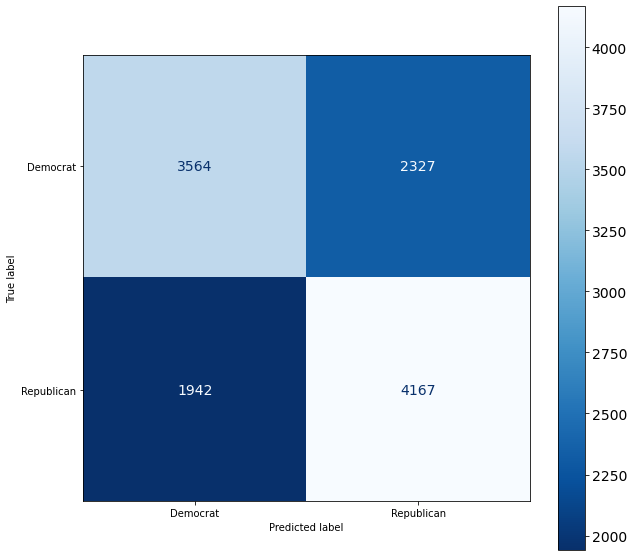

In [26]:
# Evaluate lda model created above the hyperparameter optimization.
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# Get topic vectors from trigrams and the lda model.
df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(lda_model, trigram))
df['len'] = df['topic_vec'].apply(lambda x: len(x))

# Split train and test data. Create MLPClassifier with tuned parameters.
text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=123, test_size=0.30, shuffle=True)
cl = MLPClassifier(activation='relu', alpha=0.001, hidden_layer_sizes=(250,), learning_rate='invscaling', max_iter=100, solver='lbfgs')

# Fit and predict.
cl.fit(text_train.to_list(), label_train)
prediction = cl.predict(text_test.to_list())

# Gather and display evaluation values.
confusion_mtx = confusion_matrix(label_test, prediction)
accuracy = accuracy_score(label_test, prediction)
precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')

print("Confusion:\n " + str(confusion_mtx))
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1Score: " + str(fscore))

fig, ax_cm = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Blues_r)
plt.savefig("img/mlp_confusion_matrix.pdf")
plt.show()

In [34]:
# Create interactive topic model visualization using pyLDAvis.
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26    -0.131573  0.148459       1        1  3.079187
9     -0.008680  0.010202       2        1  2.304366
11     0.143038 -0.008674       3        1  1.968571
52     0.098243 -0.032338       4        1  1.959776
34     0.135287  0.060455       5        1  1.893106
28     0.057503 -0.135914       6        1  1.861813
51     0.098919  0.073441       7        1  1.856275
45    -0.103390 -0.206548       8        1  1.821926
2      0.041777  0.121451       9        1  1.819944
38    -0.028539  0.060666      10        1  1.800263
1      0.214276 -0.024019      11        1  1.781972
14     0.164610  0.036157      12        1  1.755253
46     0.119743  0.116566      13        1  1.746549
43     0.098363 -0.198611      14        1  1.744621
54     0.049166 -0.066532      15        1  1.742235
42    -0.078650  0.013078      16        1  1.722600
39    -0.108681  0.103265      17        1  1.706895
27    -0.195755  0.093606      18        1  1.699277
5     -0.120234 -0.066545      19        1  1.697148
44    -0.176765 -0.094925      20        1  1.679274
22    -0.017233  0.165323      21        1  1.676434
59    -0.181608  0.156904      22        1  1.673289
17     0.206572 -0.071403      23        1  1.671298
48    -0.067500 -0.117419      24        1  1.670518
13     0.045664 -0.224849      25        1  1.670212
8     -0.207162  0.008958      26        1  1.653527
7     -0.197433 -0.058534      27        1  1.643822
20    -0.130604 -0.094872      28        1  1.642069
56    -0.116956 -0.149645      29        1  1.635704
6     -0.152184  0.026434      30        1  1.634265
4      0.118994  0.151047      31        1  1.623011
50    -0.029830 -0.192478      32        1  1.618335
15     0.036881  0.046350      33        1  1.618067
12     0.150151 -0.149053      34        1  1.609189
49     0.110120 -0.085457      35        1  1.601599
30    -0.176309  0.064435      36        1  1.595635
57    -0.118065  0.062566      37        1  1.592436
18    -0.037610 -0.042238      38        1  1.586970
55    -0.004594 -0.230268      39        1  1.577638
58     0.052430 -0.000967      40        1  1.551843
23    -0.074077  0.175144      41        1  1.540522
0      0.089624 -0.156078      42        1  1.538528
31    -0.187308 -0.018451      43        1  1.538046
33     0.064981  0.160095      44        1  1.535124
24     0.182817  0.136566      45        1  1.529309
19    -0.085376  0.203782      46        1  1.528723
36    -0.056167 -0.160216      47        1  1.524063
29     0.165108 -0.078380      48        1  1.523926
37     0.015832 -0.111856      49        1  1.520006
21     0.108376  0.214979      50        1  1.486893
16    -0.104816 -0.022628      51        1  1.486217
41    -0.063846  0.118751      52        1  1.477383
32    -0.186493 -0.155565      53        1  1.474072
53    -0.019362 -0.109453      54        1  1.464815
35     0.149977 -0.130143      55        1  1.461226
40     0.001751  0.123463      56        1  1.457917
10    -0.017685  0.230790      57        1  1.452186
25     0.197925  0.083799      58        1  1.443422
47     0.037091  0.213701      59        1  1.436794
3      0.229263  0.013629      60        1  1.393917, topic_info=          Term         Freq        Total Category  logprob  loglift
315        tax  1606.000000  1606.000000  Default  30.0000  30.0000
116      thank  1989.000000  1989.000000  Default  29.0000  29.0000
422       bill  1292.000000  1292.000000  Default  28.0000  28.0000
318      great  1599.000000  1599.000000  Default  27.0000  27.0000
310        cut   678.000000   678.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
192     people    15.675785  1101.039072  Topic60  -5.4920   0.0212
47        pass    14.953907   921.888993  Topic60  -5.5391   0.1516
142       well    13.082986   458.666023  Topic60  -5.6728 

In [ ]:
# Helper function for differentiation matrix.
%matplotlib inline
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""
    import plotly.offline as py
    import plotly.graph_objs as go

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))


def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)


try:
    get_ipython()
    import plotly.offline as py
except Exception:
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

In [38]:
# Plot differentiation matrix to show how the topics differ. (Interactive plotly version is best viewed using a browser.)
mdiff, annotation = lda_model.diff(
                        lda_model,
                        # available distances: {'kullback_leibler', 'hellinger', 'jaccard', 'jensen_shannon'}
                        distance='kullback_leibler',
                    )
# Can be changed manually to "plot_difference_matplotlib" or "plot_difference_plotly".
plot_difference_plotly(mdiff, title="Topic difference", annotation=annotation)